# Results

In [92]:
library('ggplot2')
source('get_expected_pval_and_equiv_z.R')
source('multiplot.R')
source('plot_lib.R')

## 1. Robustness to units mismatch and violation of underlying assumptions

### 1.1 Robustness to unit mismatches

#### One-sample tests

##### Load the data

In [2]:
pattern = '^test1_*btw1_*'

In [3]:
# allsimudat_pval <- read.csv('../../../allsimudat_pval.csv', header=T, sep=" ")
# allsimudat_pval_rank <- read.csv('../../../allsimudat_pval_rank.csv', header=T, sep=" ")
# allsimudat_tval <- read.csv('../../../allsimudat_nopval.csv', header=T, sep=" ")
suffix <- gsub('[^a-zA-Z_0-9]', '', pattern)
csv_file = paste(getwd(), '/../../../data/allsimudat_', suffix,'.csv', sep="")

if (! file.exists(csv_file)){
    print(paste('pattern=', suffix))
    print(paste('CSV file', csv_file,' not found, reprocessing the data.'))
    get_expected_pval_and_equiv_z(pattern)
}

##### Agregate data from all repetitions and experiments

#### Load the data from the CSV file

In [4]:
pattern_btw1 <- '^test1_*btw1_*'
suffix_btw1 <- gsub('[^a-zA-Z_0-9]', '', pattern_btw1)
csv_file_btw1 <- paste(getwd(), '/../../../data/allsimudat_', suffix_btw1,'.csv', sep="")
allsimudat_btw1 <- read.csv(csv_file_btw1, header=T, sep=",")

In [5]:
pattern_btw0 <- '^test1_*btw0_*'
suffix_btw0 <- gsub('[^a-zA-Z_0-9]', '', pattern_btw0)
csv_file_btw0 <- paste(getwd(), '/../../../data/allsimudat_', suffix_btw0,'.csv', sep="")
allsimudat_btw0 <- read.csv(csv_file_btw0, header=T, sep=",")

In [10]:
suffix <- 'test1'
allsimudat <- rbind(allsimudat_btw1, allsimudat_btw0)

In [162]:
# Reorder unit mismatch factor levels
allsimudat$unitMism = factor(allsimudat$unitMism,c('nominal', 'contscl', 'datascl'))

##### Plots

###### Units mismtach

We look how contrast-based methods are affected by the units issue.

In [163]:
con_methods <- c("megaMFX","megaRFX","permutCon", "megaFFX_FSL")
con_data <- subset(allsimudat, is.finite(expectedz) & expectedz>0 &  (allsimudat$methods %in% con_methods) & allsimudat$glm == 1 )

We look at the best case scenario for each contrast-based method:
 - MFX GLM: τ2 ≠ 0 -> τ2 = 1
 - RFX GLM: σ2<<τ2 or σ2 (and n) constant for all studies -> σ2=1/2
 - Contrast Permutation: anything
 - FFX GLM: τ2 = 0

In [164]:
best_con_data <- subset(con_data, 
    ((con_data$methods %in% c("megaMFX","megaRFX","permutCon") & con_data$Between==1) |
    ((con_data$methods %in% c("megaFFX_FSL") & con_data$Between==0))) & 
    con_data$Within==5 & 
    ((con_data$glm == 1 & con_data$nStudies==25) | (con_data$glm > 1 & con_data$nStudies==50)))

Warning message:
“Removed 1393 rows containing missing values (geom_path).”

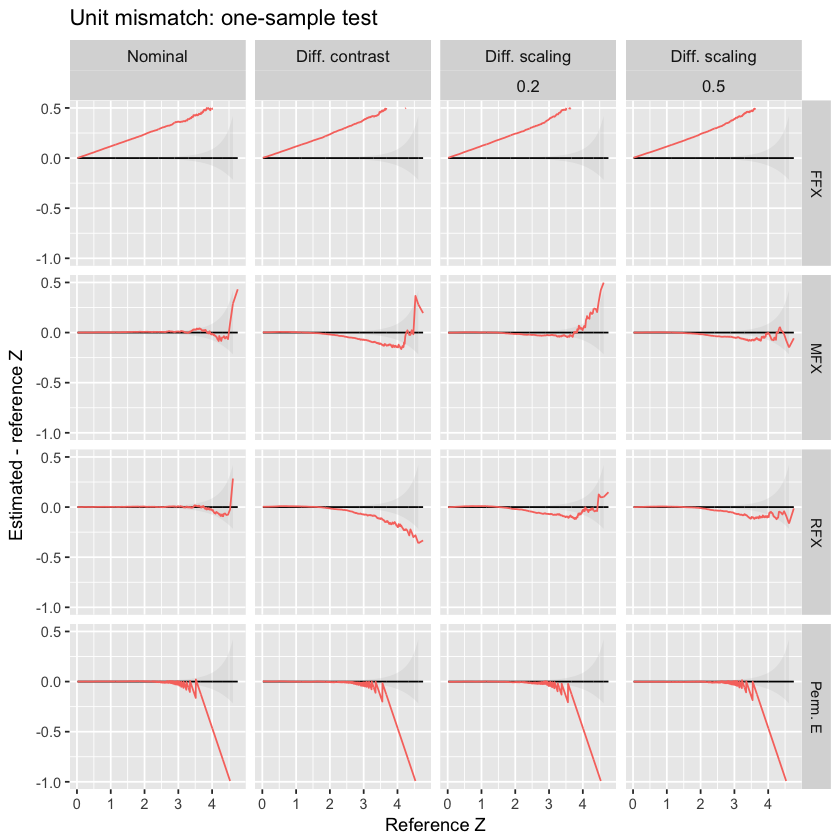

In [166]:
source('plot_lib.R')
plot_unit_mismatch(best_con_data, 'one-sample test', mult=FALSE, single=TRUE)

###### Nominal plot (no units mismatch)

In [28]:
best_con_data <- c

###### Recreate old plots

In [11]:
# Methods of interest
#selected_methods <- c("megaMFX","megaRFX","permutCon","permutZ","stouffersMFX")
selected_methods <- c("megaMFX","megaRFX","permutCon")

In [18]:
# data_subset <- subset(allsimudat, expectedz>0 &  nStudies>10 & Between==0 &  (allsimudat$methods not %in% selected_methods)  & !(allsimudat$methods %in% c("megaFFX")) & glm==1)

# expectedz is minus infinity if expected p is 1 which happens when rank = sample_size
# we look only at positive effect (expectedz>0), supposedly this should be more or less symmetric...?
data_subset <- subset(allsimudat, is.finite(expectedz) & expectedz>0 &  (allsimudat$methods %in% selected_methods) )

data_subset$units <- paste(data_subset$unitMism, data_subset$soft2Factor)

# Reorder the data frame to have nominal first
data_subset <- data_subset[order(c(data_subset$soft2, data_subset$soft2Factor, data_subset$units)), ]


In [19]:
subplot=list()
titles=list()

data_subset_btw1 <- subset(data_subset, data_subset$Between==1 )
suffix <- 'test1_btw1'

titles[[1]] <- paste("Nominal (", suffix,")") 
subplot[[1]] <- subset(data_subset_btw1, unitMism=="nominal")
#subplot[[1]] <- data_subset

titles[[2]] <- "Different scaling target"
subplot[[2]] <- subset(data_subset_btw1, unitMism=="datascl" & soft2Factor==100)

titles[[3]] <- "Different scaling algorithm (same target)"
subplot[[3]] <- subset(data_subset_btw1, unitMism=="datascl" & soft2Factor!=100)

titles[[4]] <- "Different contrast vector scaling"
subplot[[4]] <- subset(data_subset_btw1, soft2==0 & unitMism=="contscl")



#methods=="megaRFX")

allsimudat$Within <- factor(allsimudat$Within)


 # 


#methods=="permutCon" & Between==1 & nStudies==50 & numSubjectScheme=="identical" & varScheme=="identical" & Within==5)
#

# # # With the plot below, we can check if things went wrong (i.e. expected z-stat not incremental)
# p <- ggplot(data_subset, aes(as.factor(equivz), expectedz, colour=factor(paste(Within))))
# p + geom_boxplot() + stat_summary(fun.y=mean, colour="red", geom="point", shape=18, size=3,show_guide = FALSE) + facet_grid(methods+Between ~ nStudies+ numSubjectScheme) 

# p <- ggplot(data_subset, aes(as.factor(equivz), equivz-expectedz, colour=factor(paste(Within))))


# Bland-Altman like
subpl=list()


for (i in 1:4){
	subpl[[i]] <- ggplot(data=subplot[[i]],aes(x=expectedz, y=equivz-expectedz, group=allgroups, colour=factor(Within)))
	
	subpl[[i]] <- subpl[[i]] + 
        geom_ribbon(
            aes(x=expectedz, ymin=z_lower-expectedz, ymax=z_upper-expectedz), 
            fill="grey", alpha=.2, colour=NA) + 
        facet_grid(methods~nStudies+soft2, scales = "free", 
                   labeller = labeller(
                       methods = method_labels, 
                       nStudies = label_both,
                       soft2 = soft2Factor_labels)) + 
        theme(strip.text.x = element_text(size = 10)) + 
        ylab("Estimated - reference Z") + xlab("Reference Z") + 
        geom_line(aes(x=expectedz, y=0), colour="black") + 
        geom_line() + 
#         geom_point(size=0.5) + 
        ggtitle(titles[[i]]) + theme(legend.position="none") + ylim(-1, 0.5)

	
	# + geom_ribbon(aes(x=expectedz, ymax = equivz_upper-expectedz, ymin= equivz_lower-expectedz), width=0.20) 
	
	# subpl[[i]] <- subpl[[i]] + geom_ribbon(aes(x=expectedz, ymin=z_lower-expectedz, ymax=z_upper-expectedz), fill="grey", alpha=.2, colour=NA) + facet_grid(Between + methods + nStudies + glm ~ unitMismatch+soft2Factor+ soft2, labeller=facet_labeller) + theme(strip.text.x = element_text(size = 16)) + ylab("Difference between estimated and reference z-statistic") + xlab("Reference z-statistic") + geom_line(aes(x=expectedz, y=0), colour="black") + geom_line() + geom_point(size=1) 
}

###### Actual plot

Warning message:
“Removed 2886 rows containing missing values (geom_path).”

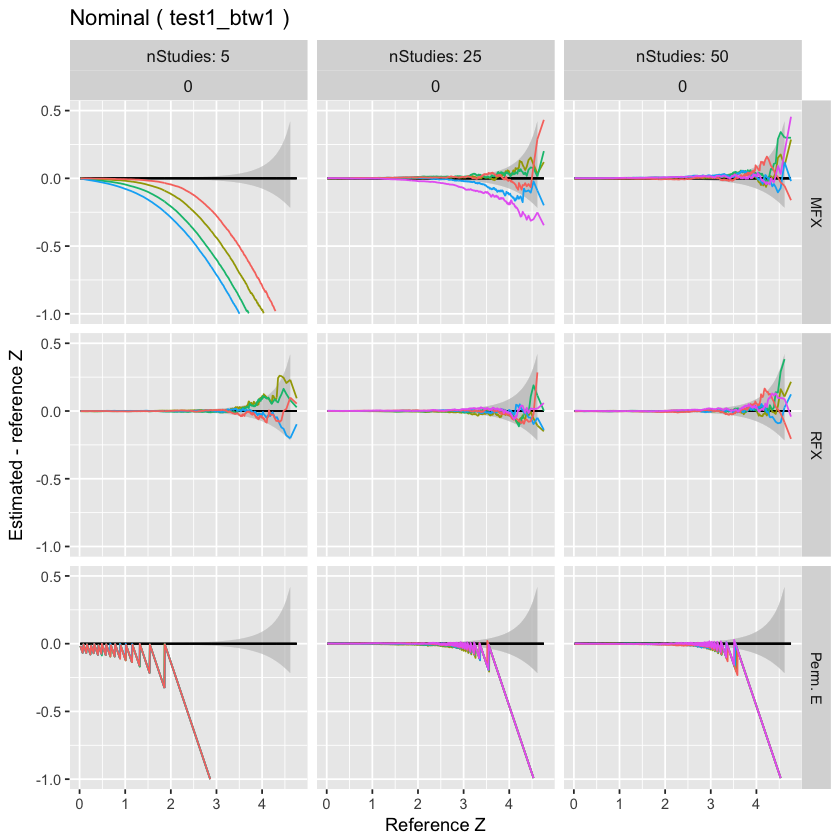

In [20]:
subpl[[1]]

Warning message:
“Removed 2886 rows containing missing values (geom_path).”Warning message:
“Removed 3440 rows containing missing values (geom_path).”Warning message:
“Removed 6880 rows containing missing values (geom_path).”

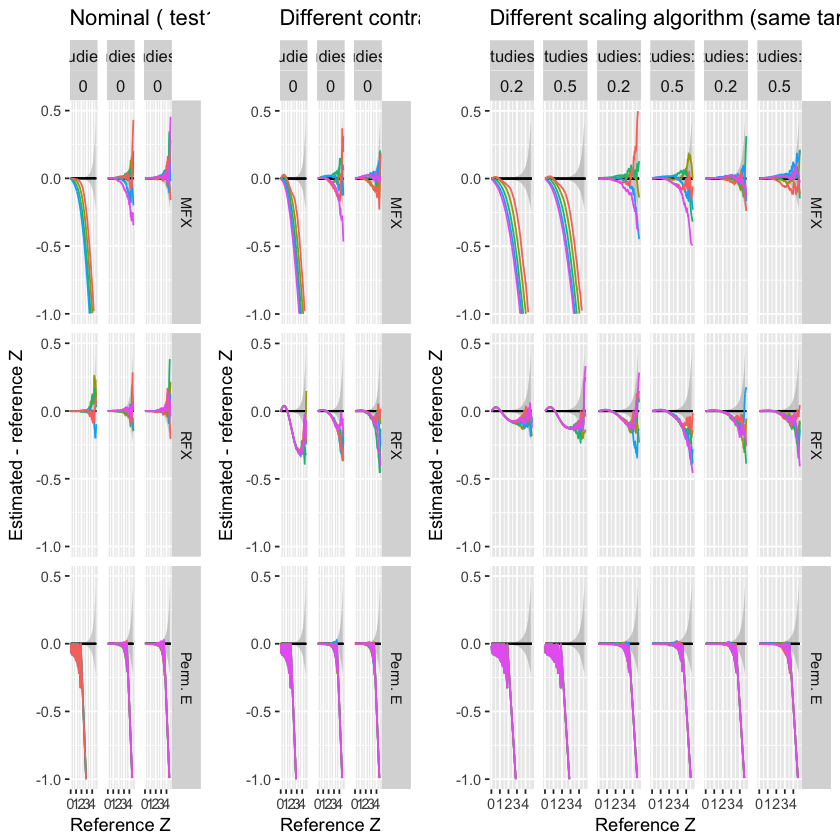

In [21]:
multiplot(subpl[[1]], subpl[[4]], subpl[[3]], layout=matrix(c(1,2,3,3), nrow=1, byrow=TRUE))